<a href="https://colab.research.google.com/github/NinelK/SA_DS_tutorial/blob/main/DS_Tutorial_Part_3_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Neural population dynamics

## Setups

In [1]:
import datetime
import h5py
import jax.numpy as jnp
from jax import random
from jax.experimental import optimizers
from jax.config import config
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as np  # original CPU-backed NumPy
import scipy.signal
import scipy.stats
import os
import sys
import time
from importlib import reload

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [2]:
%%capture
! pip install "dandi>=0.13.0"
! pip install git+https://github.com/neurallatents/nlb_tools.git
! git clone -b SA_tutorial https://github.com/NinelK/jax-lfads.git

In [3]:
# You must change this to the location of the computation-thru-dynamics directory.
HOME_DIR = '/content' 

sys.path.append(os.path.join(HOME_DIR,'jax-lfads'))
import lfads_tutorial.lfads as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun
from lfads_tutorial.lfads import sigmoid

import matplotlib.pyplot as plt
import pandas as pd
from nlb_tools.nwb_interface import NWBDataset


In [4]:
# Make directories
lfads_dir = '/content/lfads/'       # where to save lfads data and parameters to
output_dir = os.path.join(lfads_dir, 'output/')
figure_dir = os.path.join(lfads_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(lfads_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

## Introduction

In recent years, progress in recording technologies enabled recordings of 100-1000-10000 of neurons simultaneously.

At the same time, it was shown that neural population activity often has a low-dimensional structure: a low number of latent dynamical factors can explain a large fraction of neural variability. This finding is called a 'manifold hypothesis', and was proposed in [Vyas et al. 2020](#references).



## Downloading MC_MAZE dataset from DANDI repository

![MC_Maze](https://neurallatents.github.io/assets/maze_fig1.png)

The maze task is a delayed center-out reach task with barriers, resulting in a variety of straight and curved trajectories. Neural activity was recorded from the dorsal premotor and primary motor cortices, and cursor, monkey gaze position, and monkey hand position and velocity are also provided.

It has been found that M1/PMd activity during such planned, highly-stereotyped movements is predictable from neural population state at movement onset. Though this does not imply the neural system is itself autonomous, predictability makes the dataset useful for evaluating a method’s ability to model autonomous dynamics. In addition to a standard session, we provide 3 recording sessions (standard, large, medium, and small) with varying numbers of trials in order to test how modeling methods scale to limited data.

[*Source: https://neurallatents.github.io/datasets.html*]

The 4 recording sessions released on DANDI are provided by Matt Kaufman, Mark Churchland, and Krishna Shenoy at Stanford University.

Downloading the dataset from DANDI takes just 1 line:

In [5]:
# ! dandi download DANDI:000140/0.220113.0408 # Small
# ! dandi download DANDI:000138/0.220113.0407 # Large
# ! dandi download https://dandiarchive.org/dandiset/000129/draft
# ! dandi download https://dandiarchive.org/dandiset/000070/draft
! dandi download DANDI:000128/0.220113.0400 # Standard (should be called EXTRA-SUPER-LARGE-130 Gb RAM dataset)

2022-08-05 17:44:58,675 [    INFO] NumExpr defaulting to 4 threads.
PATH                                                             SIZE      DONE    DONE% CHECKSUM STATUS    MESSAGE    
dandiset.yaml                                                                                     skipped   no change  
sub-Jenkins/sub-Jenkins_ses-full_desc-test_ecephys.nwb                                                                 
sub-Jenkins/sub-Jenkins_ses-full_desc-train_behavior+ecephys.nwb                                                       
Summary:                                                         0 Bytes   0 Bytes                1 skipped 1 no change
                                                                 +694.0 MB 0.00%                                       


ERROR: 2 asynchronous workers failed

Producing value for row ('sub-Jenkins/sub-Jenkins_ses-full_desc-test_ecephys.nwb',) failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-package

Because the data in DANDI repositories is standardised according to Neuroscience Without Borders (NWB) standards, we can use ready-made data loaders for this format:

In [6]:
# we are using a dataloader from NLB tools 
dataset = NWBDataset("/content/000128/sub-Jenkins", "*train", 
                     split_heldout=False)

bin = 10 # [ms]
dataset.resample(bin)

# to view the dataset, uncomment the next line
# dataset.data

Let us get familiar with the dataset. How many trials does it have?

In [7]:
dataset.trial_info

,trial_id,start_time,end_time,trial_type,trial_version,maze_id,success,target_on_time,go_cue_time,move_onset_time,rt,delay,num_targets,target_pos,num_barriers,barrier_pos,active_target,split
0,0,0 days 00:00:00,0 days 00:00:03.321000,25,2,84,True,0 days 00:00:00.880000,0 days 00:00:01.478000,0 days 00:00:01.905000,427,598,3,"[[-111, -82], [-108, 81], [118, 72]]",8,"[[69, 31, 14, 99], [69, 54, 5, 101], [-62, -48...",2,val
1,1,0 days 00:00:03.400000,0 days 00:00:06.521000,3,1,3,True,0 days 00:00:04.291000,0 days 00:00:04.739000,0 days 00:00:05.280000,541,448,1,"[[-116, -5]]",6,"[[-69, -16, 13, 69], [-120, -62, 83, 15], [95,...",0,val
2,2,0 days 00:00:06.600000,0 days 00:00:09.856000,22,1,66,True,0 days 00:00:07.471000,0 days 00:00:07.969000,0 days 00:00:08.346000,377,498,1,"[[-82, -86]]",9,"[[34, -41, 86, 8], [9, -42, 33, 19], [7, -41, ...",0,train
3,3,0 days 00:00:09.900000,0 days 00:00:12.946000,29,2,100,True,0 days 00:00:10.853000,0 days 00:00:11.335000,0 days 00:00:11.752000,417,482,3,"[[-109, 2], [2, 82], [132, -65]]",9,"[[-9, 52, 43, 8], [-50, 91, 14, 64], [-133, -5...",1,train
4,4,0 days 00:00:13,0 days 00:00:15.481000,21,0,65,True,0 days 00:00:13.687000,0 days 00:00:14.235000,0 days 00:00:14.507000,272,548,1,"[[27, 82]]",0,[],0,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,2290,0 days 01:55:36.600000,0 days 01:55:39.796000,34,1,91,True,0 days 01:55:37.362000,0 days 01:55:38.277000,0 days 01:55:38.585000,308,915,1,"[[116, -77]]",7,"[[66, -43, 30, 9], [-66, 1, 11, 70], [-35, 50,...",0,train
2291,2291,0 days 01:55:39.900000,0 days 01:55:42.736000,15,1,75,True,0 days 01:55:40.717000,0 days 01:55:41.265000,0 days 01:55:41.641000,376,548,1,"[[133, -81]]",9,"[[-33, 47, 37, 6], [-77, 48, 61, 11], [-64, -2...",0,train
2292,2292,0 days 01:55:42.800000,0 days 01:55:45.766000,23,0,67,True,0 days 01:55:43.465000,0 days 01:55:44.396000,0 days 01:55:44.714000,318,931,1,"[[94, -86]]",0,[],0,train
2293,2293,0 days 01:55:45.800000,0 days 01:55:49.201000,25,2,84,True,0 days 01:55:46.631000,0 days 01:55:46.663000,0 days 01:55:47.616000,953,32,3,"[[-111, -82], [-108, 81], [118, 72]]",8,"[[69, 31, 14, 99], [69, 54, 5, 101], [-62, -48...",2,val


## Preparing data for trial-average analysis

### Principle component analysis (PCA)

#### Exercise 1:

### Detecting rotational dynamics with jPCA (optional)

# Part 4: Recurrent neural networks (RNNs) as models of latent neural dynamics

### Vanilla RNN


Let us first consider the simplest, yet most important example of a non-linear discrete-time latent dynamical system: recurrent neural network. It is a go-to tool for modelling sequences in deep learning.

Latent dynamics: $$h_{t} = \sigma (V h_{t-1} + U x_t + b_h)$$
Emission model: $$o_t = W h_t + b_o $$


![RNN scheme (Wiki)](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/2560px-Recurrent_neural_network_unfold.svg.png)


TODO: SLIDE ON BPTT

#### Exercise 2: Implement a Vanilla RNN

In [8]:
def vanilla_rnn_params(key, n, u, ifactor=1.0, hfactor=.001, hscale=0.0):
  """Generate Vanilla RNN parameters

  Arguments:
    key: random.PRNGKey for random bits
    n: hidden state size
    u: input size
    ifactor: scaling factor for input weights
    hfactor: scaling factor for hidden -> hidden weights
    hscale: scale on h0 initial condition

  Returns:
    a dictionary of parameters
  """
  key, skeys = utils.keygen(key, 3)
  ifactor = ifactor / jnp.sqrt(u)
  hfactor = hfactor / jnp.sqrt(n)

  h0 = random.normal(next(skeys), (n,)) * hscale
  wA = random.normal(next(skeys), (n,n)) * hfactor
  wB = random.normal(next(skeys), (n,u)) * ifactor
  wb = jnp.zeros((n,))

  return {'h0' : h0,
          'wA' : wA,
          'wB' : wB,
          'wb' : wb}


def vanilla_rnn(params, h, x, nonlin=jnp.tanh):
  """Implement the Vanilla RNN equations.

  Arguments:
    params: dictionary of RNN parameters
    h: np array of hidden state
    x: np array of input

  Returns:
    np array of hidden state after RNN update"""
  h_new = nonlin(jnp.dot(params['wA'], h) + jnp.dot(params['wB'], x) + params['wb'])
  return h_new


#### Exercise 3: Generate some spike data from a VRNN

## Inferring dynamics & initial conditions using LFADS

Auto-encoding sequential neural data with RNN-based LFADS model 

#### Align and slice the data as [trials x time x neurons]

In [9]:
input_key = 'spikes'
output_key = 'hand_vel'

# Extract neural data and lagged hand velocity
trial_length = 800//bin
trial_data = dataset.make_trial_data(align_field='move_onset_time', 
                                     align_range=(-200, -200+bin*trial_length))

print(trial_data['trial_id'].to_numpy().reshape((-1,trial_length)))
inputs = trial_data[input_key].to_numpy() 
outputs = trial_data[output_key].to_numpy()

input_size = inputs.shape[-1]
output_size = outputs.shape[-1]

print(input_size,output_size)

inputs = inputs.reshape((-1,trial_length,input_size)) # [trials x time x inputs]
outputs = outputs.reshape((-1,trial_length,output_size)) # [trials x time x outputs]
 
data_bxtxn = inputs
data_bxtxn.shape

[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [2292 2292 2292 ... 2292 2292 2292]
 [2293 2293 2293 ... 2293 2293 2293]
 [2294 2294 2294 ... 2294 2294 2294]]
182 2


(2295, 80, 182)

In [10]:
data_dt = 10.0        # define our dt in a physiological range [ms]

train_fraction = 0.9      # Train with 90% of the synthetic data

nexamples, ntimesteps, data_dim = data_bxtxn.shape

train_data, eval_data = utils.split_data(data_bxtxn,
                                         train_fraction=train_fraction)
eval_data_offset = int(train_fraction * data_bxtxn.shape[0])

# find reach directions for labeling
conds = dataset.trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()
# Loop over conditions and compute average trajectory
reach_angle = np.empty(len(dataset.trial_info)).astype('float32')
for cond in conds:
    # Find trials in condition
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    # Determine reach angle for color
    active_target = dataset.trial_info[mask].target_pos.iloc[0][dataset.trial_info[mask].active_target.iloc[0]]
    reach_angle[mask] = np.arctan2(*active_target[::-1])

#### Check basic stats

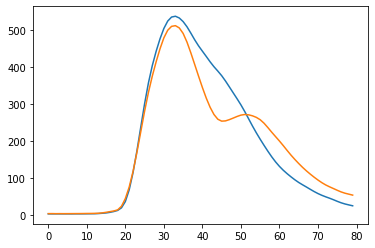

In [11]:
plt.plot(outputs.std(0))

In [12]:
eval_data.shape

(230, 80, 182)

In [13]:
import sklearn
ncomponents = data_dim
full_pca = sklearn.decomposition.PCA(ncomponents)
full_pca.fit(np.reshape(data_bxtxn, [-1, data_dim]))

PCA(n_components=182)

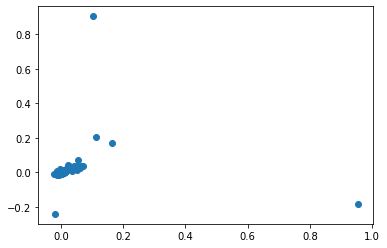

In [14]:
plt.scatter(*full_pca.components_[:2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


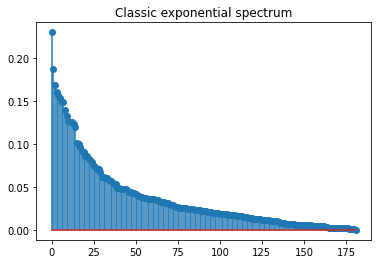

In [15]:
plt.stem(full_pca.explained_variance_)
plt.title('Classic exponential spectrum');

### Set LFADS Parameters

In [16]:
# LFADS Hyper parameters
data_dim = train_data.shape[2]  # input to lfads should have dimensions:
ntimesteps = train_data.shape[1] #   (batch_size x ntimesteps x data_dim)
batch_size = 200      # batch size during optimization

# LFADS architecture - The size of the numbers is rather arbitrary, 
# but relatively small because we know the integrator RNN isn't too high 
# dimensional in its activity.
enc_dim = 64         # encoder dim
con_dim = 0          # controller dim
ii_dim = 0           # inferred input dim
gen_dim = 64         # generator dim, should be large enough
factors_dim = 8      # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
var_min = 0.001 # Minimal variance any gaussian can become.

# Optimization HPs that percolates into model
l2reg = 0.00002

# Initial state prior parameters
# the mean is set to zero in the code
ic_prior_var = 0.1 # this is $\sigma^2_p$ in above paragraph

# Inferred input autoregressive prior parameters
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

lfads_hps = {'data_dim' : data_dim, 'ntimesteps' : ntimesteps,
             'enc_dim' : enc_dim, 'con_dim' : con_dim, 'var_min' : var_min,
             'ic_prior_var' : ic_prior_var, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : ii_dim, 'gen_dim' : gen_dim,
             'factors_dim' : factors_dim,
             'l2reg' : l2reg,
             'batch_size' : batch_size}

num_batches = 20000         # how many batches do we train
print_every = 100            # give information every so often

# Learning rate HPs
step_size = 0.01            # initial learning rate
decay_factor = 0.9998       # learning rate decay param
decay_steps = 1             # learning rate decay param

# Regularization HPs
keep_rate = 0.95             # dropout keep rate during training

# Numerical stability HPs
max_grad_norm = 1.0        # gradient clipping above this value

# The fact that the start and end values are required to be floats is something I need to fix.
kl_warmup_start = 0.0 # batch number to start KL warm-up, explicitly float
kl_warmup_end = 1000.0  # batch number to be finished with KL warm-up, explicitly float
kl_min = 0.001 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : step_size,
                 'decay_steps' : decay_steps, 'decay_factor' : decay_factor,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : max_grad_norm, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-4}

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))

lfads_hps = hashabledict(lfads_hps)
lfads_opt_hps = hashabledict(lfads_opt_hps)

assert num_batches >= print_every and num_batches % print_every == 0

### Initialize LFADS

In [102]:
# Initialize parameters for LFADS
from functools import partial
nonlin = lambda x: jnp.tanh(x)
# model = partial(vanilla_rnn, **{'nonlin': nonlin})
# model_params = vanilla_rnn_params

# to get the results line in Nature Methods
model = lfads.gru
model_params = lfads.gru_params

key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
init_params = lfads.lfads_params(key, lfads_hps, gen_rnn_params=model_params)

### Option 1: Train LFADS

In [18]:
# # Takes 12 minutes to train on a GPU; first step takes ~20 sec.
# key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
# trained_params, opt_details = \
#     optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,\
#                    train_data, eval_data, gen=model)

In [19]:
# fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
# network_fname = ('trained_params_lfads_128_vrnn' + fname_uniquifier + '.npz')
# network_path = os.path.join(output_dir, network_fname)

# print("Saving parameters: ", network_path)
# np.savez(network_path, trained_params)


In [20]:
# # Plot the training details
# x = np.arange(0, num_batches, print_every)
# plt.figure(figsize=(20,6))
# plt.subplot(251)
# plt.plot(x, opt_details['tlosses']['total'], 'k')
# plt.ylabel('Training')
# plt.title('Total loss')
# plt.subplot(252)
# plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
# plt.title('Negative log p(z|x)')
# plt.subplot(253)
# plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
# plt.title('KL inferred inputs')
# plt.subplot(254)
# plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
# plt.title('KL initial state')
# plt.subplot(255)
# plt.plot(x, opt_details['tlosses']['l2'], 'c')
# plt.xlabel('Training batch')
# plt.title('L2 loss')
# plt.subplot(256)
# plt.plot(x, opt_details['elosses']['total'], 'k')
# plt.xlabel('Training batch')
# plt.ylabel('Evaluation')
# plt.subplot(257)
# plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
# plt.xlabel('Training batch')
# plt.subplot(258)
# plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
# plt.xlabel('Training batch')
# plt.subplot(259)
# plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
# plt.xlabel('Training batch');

In [21]:
# # See the effect of the KL warmup, which is shown 
# # by the KL penalities without the warmup scaling. 
# plt.figure(figsize=(7,4))
# plt.subplot(221)
# plt.plot(x, opt_details['tlosses']['kl_ii_prescale'], 'r--')
# plt.ylabel('Training')
# plt.subplot(222)
# plt.plot(x, opt_details['tlosses']['kl_g0_prescale'], 'g--')
# plt.subplot(223)
# plt.plot(x, opt_details['elosses']['kl_ii_prescale'], 'r--')
# plt.ylabel('Evaluation')
# plt.xlabel('Training batch')
# plt.subplot(224)
# plt.plot(x, opt_details['elosses']['kl_g0_prescale'], 'g--')
# plt.xlabel('Training batch');

### Option 2: Load pre-trained model from file

In [103]:
# After training, you can load these up, after locating the save file.
# network_fname = 'trained_params_lfads_128_vrnn2022-08-05_14:02:03.npz'
network_fname = 'trained_params_lfads_128_gru2022-08-05_12:54:43.npz'
network_path = os.path.join(output_dir, network_fname)

loaded_params = np.load(network_path, allow_pickle=True)
trained_params = loaded_params['arr_0'].item()


## Visualize latent space trajectories

In [104]:
# Plot a bunch of examples of eval trials run through LFADS.
reload(plotting)
#reload(lfads)

def plot_rescale_fun(a): 
    fac = max_firing_rate * data_dt
    return renormed_fun(a) * fac


bidx = 0

nexamples_to_save = 1
for eidx in range(nexamples_to_save):
    fkey = random.fold_in(key, eidx)
    psa_example = eval_data[bidx,:,:].astype(jnp.float32)
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)

    # The inferred input and true input are rescaled and shifted via 
    # linear regression to match, as there is an identifiability issue. there.
    # plotting.plot_lfads(psa_example, psa_dict,
    #                     data_dict, eval_data_offset+bidx, plot_rescale_fun)


dict_keys(['c_t', 'factor_t', 'gen_t', 'ic_logvar', 'ic_mean', 'ii_logvar_t', 'ii_mean_t', 'ii_t', 'lograte_t', 'xenc_t'])

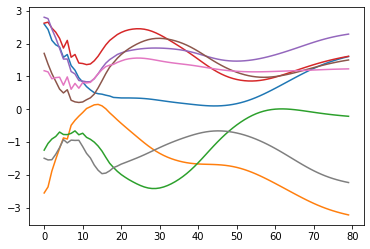

In [105]:
# plt.plot(psa_dict['factor_t'])
plt.plot(psa_dict['factor_t'])
psa_dict.keys()

In [106]:
# sample trajectories
ics = np.empty((data_bxtxn.shape[0],gen_dim))
gen_traj = np.empty((data_bxtxn.shape[0],ntimesteps,gen_dim))
for i, psa_example in enumerate(data_bxtxn.astype(jnp.float32)):
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)
    ics[i] = psa_dict['ic_mean']
    gen_traj[i] = psa_dict['gen_t']

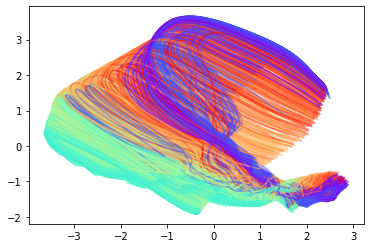

In [107]:
ncomponents = 3
pca = sklearn.decomposition.PCA(ncomponents)
pca.fit(np.reshape(gen_traj, [-1, gen_dim]))

S = pca.components_.T

for a,t in zip(reach_angle,gen_traj):
  plt.plot(*(t@S)[:,[1,2]].T, c=plt.cm.rainbow(a / (2*np.pi) + 0.5),alpha=0.5)



In [108]:
import plotly.express as px
import pandas as pd

# print((gen_traj@S)[:,0])

df = pd.DataFrame.from_dict({'PC0': (gen_traj@S)[::10,:,0].flatten(),
                             'PC1': (gen_traj@S)[::10,:,1].flatten(),
                             'PC2': (gen_traj@S)[::10,:,2].flatten(),
                             'color': reach_angle[::10].repeat(ntimesteps).T})

fig = px.scatter_3d(df, x="PC0", y="PC1", z="PC2",color='color')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=.01,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



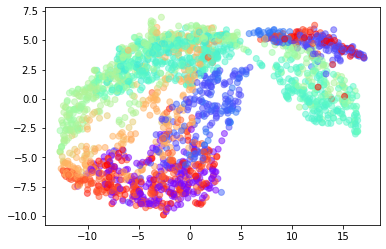

In [109]:
from sklearn.manifold import TSNE

ncomponents = 3
tsne = TSNE(ncomponents)#,perplexity=20)
embedded_ics = tsne.fit_transform(ics)

plt.scatter(*embedded_ics[:,:2].T, c=plt.cm.rainbow(reach_angle[:] / (2*np.pi) + 0.5),alpha=0.5)

## Fixed point analysis

In [110]:
%load_ext autoreload
%autoreload 2
import fixed_point_finder.fixed_points as fp_optimize
from jax import vmap
import gc

gc.collect() # free up some RAM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


175361

In [111]:
# These are some preliminaries. 
x_star = np.zeros(ii_dim)  # We always linearize the input around zero in this example.

# Make a one parameter function of thie hidden state, useful for jacobians.
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
params = hashabledict(model_params(key, gen_dim, ii_dim))
rnn_fun = lambda h : model(params, h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))


#### Create some functions that define the fixed point loss
which is just the squared error of a point  for a discrete time system such as a VRNN or GRU.

In [112]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

We have to start the fixed point finder with some points, and it's always best to start with examples of where the state normally operates.


In [113]:
fp_candidates = jnp.array(gen_traj[::50,])                        # was batch x time x dim
fp_candidates = jnp.reshape(fp_candidates, (-1, gen_dim))  # now (batch * time) x dim

In [117]:
# Fixed point optimization hyperparameters
fp_num_batches = 1000         # Total number of batches to train on.
fp_batch_size = 100          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025      # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.


In [118]:
fp_candidates.shape

(3680, 64)

When optimizing for fixed points, we set a few different stopping thresholds and run the fixed point finder a few times. This is because there are rarely true numerical fixed points, though they do happen. Instead one has slow points of varying slowness. My experience is that if the dynamics of the slow point is very slow relative to the normal speed of the dynamics during the task / computation / behavior, then the slow point is effectively acting as a fixed point. Moving forward, in the code, and in the comments, I always refer to slow points as fixed points, with the understanding that we are being informal. By having a few tolerances of varying slowness, we ensure we capture a large variety of the fixed points and likely get a better understanding of what the system is doing.

In [119]:
reload(fp_optimize)

fp_tols = [0.0001, 0.00001, 0.000001] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
  fp_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
            'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
            'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2,
            'adam_eps' : fp_adam_eps, 'noise_var' : fp_noise_var, 
            'fp_opt_stop_tol' : tol, 'fp_tol' : tol, 
            'unique_tol' : fp_unique_tol, 'outlier_tol' : fp_outlier_tol, 
            'opt_print_every' : fp_opt_print_every}

  fp_hps = hashabledict(fp_hps)

  fps, fp_losses, fp_idxs, fp_opt_details = \
    fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
  if len(fp_idxs) > 0:
      F_of_fps = batch_rnn_fun(fps)
  else:
      F_of_fps = np.zeros([0,gen_dim])
      
  all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                  'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                  'opt_details' : fp_opt_details, 'hps' : fp_hps}

  all_fps[tol]


Optimizing to find fixed points.
    Batches 1-200 in 0.57 sec, Step size: 0.19604, Training loss 0.00020
    Batches 201-400 in 0.07 sec, Step size: 0.19216, Training loss 0.00002
Stopping as mean training loss 0.00002 is below tolerance 0.00010.
Excluding fixed points with squared speed above tolerance 0.00010.
    Kept 3674/3680 fixed points with tolerance under 0.000100.
Excluding non-unique fixed points.
    Kept 409/3674 unique fixed points with uniqueness tolerance 0.025000.
Excluding outliers.
    Kept 409/409 fixed points with within outlier tolerance 1.000000.
Sorting fixed points slowest first.
Optimizing to find fixed points.
    Batches 1-200 in 0.44 sec, Step size: 0.19604, Training loss 0.00020
    Batches 201-400 in 0.06 sec, Step size: 0.19216, Training loss 0.00002
    Batches 401-600 in 0.07 sec, Step size: 0.18835, Training loss 0.00000
Stopping as mean training loss 0.00000 is below tolerance 0.00001.
Excluding fixed points with squared speed above tolerance 0.0000

In [131]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# print((gen_traj@S)[:,0])

df = pd.DataFrame.from_dict({'PC0': (gen_traj@S)[::10,:,0].flatten(),
                             'PC1': (gen_traj@S)[::10,:,1].flatten(),
                             'PC2': (gen_traj@S)[::10,:,2].flatten(),
                             'color': reach_angle[::10].repeat(ntimesteps).T})

fig = px.scatter_3d(df, x="PC0", y="PC1", z="PC2",color='color')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=.01,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fixed_points = all_fps[0.000001]['fps'] @ S
print(fixed_points.shape)

fig.add_trace(
    go.Scatter3d(x=fixed_points[:,0],
                 y=fixed_points[:,1],
                 z=fixed_points[:,2],
                 mode='markers')
)
fig.show()


(1, 3)


In [121]:
fixed_points

DeviceArray([[ 0.00554681, -0.00077618, -0.00336324]], dtype=float32)

### Exercise 4: Linearizing around the fixed point: calculating the Jacobian

Since we used a Vanilla RNN, we can now write down the Jacobian analytically. We assumed autonomous dynamics:

$$\mathbf{x}_{fp} \approx tanh(\mathrm{A}\mathbf{x}_{fp} + \mathbf{b}) \approx J \mathbf{x_{fp}}$$

In [99]:
A, b = trained_params['gen']['wA'], trained_params['gen']['wb']
J = A/np.cosh(b)**2

In [124]:
jacs = fp_optimize.compute_jacobians(rnn_fun, all_fps[0.000001]['fps'])
eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=False)

(-1.0, 1.0)

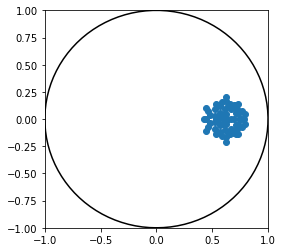

In [129]:
plt.figure(figsize=(4,4))
eigvals = eig_decomps[0]['evals']
plt.scatter(eigvals.real, eigvals.imag)
x = jnp.linspace(-jnp.pi,jnp.pi,100)
plt.plot(jnp.sin(x),jnp.cos(x),c='k')
# plt.plot(x,jnp.cos(x))
# scale = np.sqrt(eigvals.real**2 + eigvals.imag**2).max()*1.05
scale=1
plt.xlim([-scale,+scale])
plt.ylim([-scale,+scale])

In [35]:
print(trained_params.keys())
trained_params['gen'].keys()

dict_keys(['con', 'con_out', 'factors', 'gen', 'gen_ic', 'ic_enc', 'ic_prior', 'ii_prior', 'logrates'])


dict_keys(['h0', 'wA', 'wB', 'wb'])

(-3.728146827220917, 3.728146827220917)

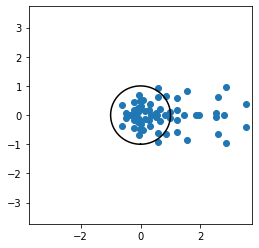

In [100]:
plt.figure(figsize=(4,4))
eigv = np.linalg.eig(J)[0]
plt.scatter(eigv.real,eigv.imag)
x = jnp.linspace(-jnp.pi,jnp.pi,100)
plt.plot(jnp.sin(x),jnp.cos(x),c='k')
# plt.plot(x,jnp.cos(x))
scale = np.sqrt(eigv.real**2 + eigv.imag**2).max()*1.05
plt.xlim([-scale,+scale])
plt.ylim([-scale,+scale])

## References
<a name="references"></a>
0. [Computation through dynamics tutorial](https://github.com/google-research/computation-thru-dynamics) from David Sussillo, which contains an implementation of LFADS that was adapted to this tutorial + extra material (in depth LFADS tutorial, slow points finder, inferring inputs, FORCE training)

1. *Manifold hypothesis:* Gallego, Juan A., et al. "Neural manifolds for the control of movement." Neuron 94.5 (2017): 978-984.

2. *A review of a population dynamics models:* Vyas, Saurabh, et al. "Computation through neural population dynamics." Annual Review of Neuroscience 43 (2020): 249. [Not paywalled pdf.](https://web.stanford.edu/~mgolub/publications/2020-Vyas-ARN.pdf)

3. *Our review on fully observed vs latent dynamical models*: Hurwitz, Cole, et al. [Building population models for large-scale neural recordings: Opportunities and pitfalls.](https://arxiv.org/pdf/2102.01807.pdf) Current Opinion in Neurobiology 70 (2021): 64-73.

4. *For better understanding of PCA:* [Dimensionality reduction tutorial](https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/chapter_title.html) by Alex Cayco Gajic at Neuromatch Academy

5. *The LFADS paper:* Pandarinath, Chethan, et al. [Inferring single-trial neural population dynamics using sequential auto-encoders.](https://www.nature.com/articles/s41592-018-0109-9) Nature methods 15.10 (2018): 805-815.

6. *Critical view on rotational dynamics* Lebedev, Mikhail A., et al. "Analysis of neuronal ensemble activity reveals the pitfalls and shortcomings of rotation dynamics." Scientific Reports 9.1 (2019): 1-14.
  
## Interesting recent papers for further reading

If you want to know what's going on in the field right now, you can check the following papers (a very biased selection from Nina ;) ):

1. Smith, Jimmy, Scott Linderman, and David Sussillo. [Reverse engineering recurrent neural networks with jacobian switching linear dynamical systems.](https://arxiv.org/pdf/2111.01256.pdf) Advances in Neural Information Processing Systems 34 (2021): 16700-16713.
2. 